<a href="https://colab.research.google.com/github/datadigger01/AI-Trade/blob/main/LSTM_forecasting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/AI와무역투자론/Data/coffee_features_clean.csv')
df.head()

,Date,Close_Price,High_Price,Low,Open,Volume,target_next_close,close_lag_1,close_lag_2,close_lag_3,...,week_of_year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,rolling_max_20,rolling_min_20,distance_from_max_20,distance_from_min_20,percentile_rank_20
0,2021-04-01,121.599998,125.449997,120.750000,124.949997,23923,122.099998,123.500000,122.599998,127.050003,...,13,0.433884,-0.900969,0.866025,-0.5,133.800003,122.599998,0.087444,0.004112,0.10
1,2021-04-05,122.099998,122.900002,120.550003,121.400002,16091,126.849998,121.599998,123.500000,122.599998,...,14,0.000000,1.000000,0.866025,-0.5,133.800003,121.599998,0.051943,0.043174,0.05
2,2021-04-06,126.849998,127.300003,121.349998,122.500000,31610,126.750000,122.099998,121.599998,123.500000,...,14,0.781831,0.623490,0.866025,-0.5,133.800003,121.599998,0.052691,0.042352,0.10
3,2021-04-07,126.750000,128.000000,125.449997,126.900002,22703,127.849998,126.849998,122.099998,121.599998,...,14,0.974928,-0.222521,0.866025,-0.5,133.800003,121.599998,0.044469,0.051398,0.45
4,2021-04-08,127.849998,128.699997,126.750000,127.000000,28825,127.250000,126.750000,126.849998,122.099998,...,14,0.433884,-0.900969,0.866025,-0.5,133.800003,121.599998,0.048954,0.046464,0.45


### Feature Selection

In [ ]:
df=df[['Date','target_next_close', 'Close_Price', 'High_Price', 'Low', 'Open',
       'close_lag_1','close_lag_2', 'open_lag_1','high_lag_1', 'low_lag_1',
       'open_lag_2', 'high_lag_2', 'low_lag_2','sma_5', 'sma_10',
       'ema_5', 'ema_10', 'ema_20','rolling_max_20', 'rolling_min_20'
       ]]

## One-step ahead forecasting with LSTM

In [ ]:
"""
LSTM 시계열 예측 모델
커피 선물 가격 예측을 위한 전체 프로세스
"""

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("LSTM 시계열 예측 모델 학습 시작")
print("=" * 80)

# ============================================================================
# 1. 데이터 로드 및 기본 탐색
# ============================================================================
print("\n[1단계] 데이터 로드 및 기본 탐색")
print("-" * 80)

# 데이터 로드
#df = pd.read_csv('/mnt/user-data/uploads/coffee_features_clean__1_.csv')

print(f"데이터 shape: {df.shape}")
print(f"결측치 개수: {df.isnull().sum().sum()} 개")
print(f"데이터 타입:\n{df.dtypes.value_counts()}")

# ============================================================================
# 2. 시계열 특성 파악
# ============================================================================
print("\n[2단계] 시계열 특성 파악")
print("-" * 80)

# Date를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'])
print(f"날짜 범위: {df['Date'].min()} ~ {df['Date'].max()}")
print(f"총 {len(df)}일 데이터")

# Target 변수 기본 통계
print(f"\ntarget_next_close 통계:")
print(f"  - 평균: {df['target_next_close'].mean():.2f}")
print(f"  - 표준편차: {df['target_next_close'].std():.2f}")
print(f"  - 최소값: {df['target_next_close'].min():.2f}")
print(f"  - 최대값: {df['target_next_close'].max():.2f}")

# ============================================================================
# 3. Feature 선택 및 전처리
# ============================================================================
print("\n[3단계] Feature 선택 및 전처리")
print("-" * 80)

# 결측치 제거
df = df.dropna()
print(f"결측치 제거 후 데이터 shape: {df.shape}")

# Date 컬럼 분리 (나중에 시각화에 사용)
dates = df['Date'].values

# 제외할 컬럼 정의
columns_to_drop = ['Date', 'target_next_close']
print(f"제외할 컬럼: {columns_to_drop}")

# Feature와 Target 분리
X = df.drop(columns_to_drop, axis=1).values
y = df['target_next_close'].values

print(f"\nFeature 개수: {X.shape[1]}")
print(f"샘플 개수: {X.shape[0]}")

# ============================================================================
# 4. 데이터 정규화
# ============================================================================
print("\n[4단계] 데이터 정규화")
print("-" * 80)

# Feature와 Target 각각 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("✓ Feature와 Target 정규화 완료")

# ============================================================================
# 5. 시퀀스 데이터 생성
# ============================================================================
print("\n[5단계] 시퀀스 데이터 생성")
print("-" * 80)

def create_sequences(X, y, time_steps=12):
    """
    시계열 데이터를 LSTM용 시퀀스로 변환

    Parameters:
    - X: Feature 데이터
    - y: Target 데이터
    - time_steps: Look-back 윈도우 크기

    Returns:
    - X_seq: (samples, time_steps, features) 형태의 3D 배열
    - y_seq: (samples,) 형태의 1D 배열
    """
    X_seq, y_seq = [], []

    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

# Look-back 윈도우 설정 (과거 10일 데이터를 사용)
TIME_STEPS = 10

X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"시퀀스 데이터 shape:")
print(f"  - X_seq: {X_seq.shape} (samples, time_steps, features)")
print(f"  - y_seq: {y_seq.shape}")

# 시퀀스 생성 후 날짜도 조정
dates_seq = dates[TIME_STEPS:]

# ============================================================================
# 6. 데이터 분할 (Train/Test)
# ============================================================================
print("\n[6단계] 데이터 분할 (Train/Test)")
print("-" * 80)

# Train/Test 분할 (시계열 순서 유지, 마지막 10%를 Test로)
train_size = int(len(X_seq) * 0.9)

X_train = X_seq[:train_size]
X_test = X_seq[train_size:]
y_train = y_seq[:train_size]
y_test = y_seq[train_size:]

dates_train = dates_seq[:train_size]
dates_test = dates_seq[train_size:]

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Train 기간: {pd.to_datetime(dates_train[0])} ~ {pd.to_datetime(dates_train[-1])}")
print(f"Test 기간: {pd.to_datetime(dates_test[0])} ~ {pd.to_datetime(dates_test[-1])}")

# ============================================================================
# 7. LSTM 모델 구축
# ============================================================================
print("\n[7단계] LSTM 모델 구축")
print("-" * 80)

def build_lstm_model(input_shape):
    """
    LSTM 모델 구축

    Parameters:
    - input_shape: (time_steps, features) 형태

    Returns:
    - model: 컴파일된 LSTM 모델
    """
    model = Sequential([
        # 첫 번째 LSTM 레이어
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # 두 번째 LSTM 레이어
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),

        # # 세 번째 LSTM 레이어
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),

        # Dense 레이어
        Dense(units=16, activation='relu'),
        Dropout(0.1),

        # 출력 레이어
        Dense(units=1)
    ])

    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# 모델 생성
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# 모델 구조 출력
print("\n모델 구조:")
model.summary()

# ============================================================================
# 8. 콜백 함수 설정
# ============================================================================
print("\n[8단계] 콜백 함수 설정")
print("-" * 80)

# Early Stopping: 검증 손실이 개선되지 않으면 조기 종료
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate 감소: 검증 손실이 개선되지 않으면 학습률 감소
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]
print("✓ EarlyStopping 및 ReduceLROnPlateau 콜백 설정 완료")

# ============================================================================
# 9. 모델 학습
# ============================================================================
print("\n[9단계] 모델 학습")
print("-" * 80)

EPOCHS = 200
BATCH_SIZE = 32

print(f"학습 설정:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Validation split: 0.1")
print("\n학습 시작...")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ 학습 완료!")

# ============================================================================
# 10. 예측 수행
# ============================================================================
print("\n[10단계] 예측 수행")
print("-" * 80)

# 정규화된 예측값
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled = model.predict(X_test, verbose=0)

# 원래 스케일로 역변환
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).flatten()

y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("✓ 예측 완료 및 역변환 완료!")

# ============================================================================
# 11. 모델 평가
# ============================================================================
print("\n[11단계] 모델 평가")
print("-" * 80)

def calculate_mape(y_true, y_pred, eps=1e-8):
    """MAPE 계산"""
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# Train 성능
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
train_mae = mean_absolute_error(y_train_original, y_train_pred)
train_mape = calculate_mape(y_train_original, y_train_pred)
train_r2 = r2_score(y_train_original, y_train_pred)

# Test 성능
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
test_mae = mean_absolute_error(y_test_original, y_test_pred)
test_mape = calculate_mape(y_test_original, y_test_pred)
test_r2 = r2_score(y_test_original, y_test_pred)

print("📊 Train Set 성능:")
print(f"  - RMSE: {train_rmse:.4f}")
print(f"  - MAE: {train_mae:.4f}")
print(f"  - MAPE: {train_mape:.4f}%")
print(f"  - R² Score: {train_r2:.4f}")

print("\n📊 Test Set 성능:")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - MAPE: {test_mape:.4f}%")
print(f"  - R² Score: {test_r2:.4f}")

# ============================================================================
# 12. 결과 시각화
# ============================================================================
print("\n[12단계] 결과 시각화")
print("-" * 80)

fig = plt.figure(figsize=(20, 12))

# 1) 학습 곡선 (Loss)
ax1 = plt.subplot(3, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2) 학습 곡선 (MAE)
ax2 = plt.subplot(3, 3, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# 3) 실제값 vs 예측값 (전체 타임라인)
ax3 = plt.subplot(3, 3, 3)
plt.plot(dates_train, y_train_original, label='Train Actual', alpha=0.6, linewidth=1)
plt.plot(dates_train, y_train_pred, label='Train Predicted', alpha=0.6, linewidth=1)
plt.plot(dates_test, y_test_original, label='Test Actual', alpha=0.9, linewidth=2)
plt.plot(dates_test, y_test_pred, label='Test Predicted', alpha=0.9, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted (Full Timeline)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 4) Test 구간 확대
ax4 = plt.subplot(3, 3, 4)
plt.plot(dates_test, y_test_original, 'o-', label='Actual', linewidth=2, markersize=6)
plt.plot(dates_test, y_test_pred, 's-', label='Predicted', linewidth=2, markersize=6)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Test Set: Actual vs Predicted (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5) Scatter Plot (Test Set)
ax5 = plt.subplot(3, 3, 5)
plt.scatter(y_test_original, y_test_pred, alpha=0.6, s=50)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted Scatter\nR² = {test_r2:.4f}')
plt.grid(True, alpha=0.3)

# 6) 잔차 분석 (Test Set)
ax6 = plt.subplot(3, 3, 6)
residuals = y_test_original - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True, alpha=0.3)

# 7) 잔차 분포
ax7 = plt.subplot(3, 3, 7)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution\nMean: {residuals.mean():.4f}')
plt.grid(True, alpha=0.3)

# 8) 예측 오차 시계열 (Test Set)
ax8 = plt.subplot(3, 3, 8)
errors = np.abs(y_test_original - y_test_pred)
plt.plot(dates_test, errors, 'o-', linewidth=2, markersize=6)
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.title(f'Prediction Error Over Time\nMean Error: {errors.mean():.4f}')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 9) 성능 메트릭 막대 그래프
ax9 = plt.subplot(3, 3, 9)
metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
scores = [test_rmse, test_mae, test_mape, test_r2]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(metrics, scores, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Score')
plt.title('Test Set Performance Metrics')
plt.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/lstm_model_results.png', dpi=300, bbox_inches='tight')
print("✓ 시각화 결과를 'lstm_model_results.png'에 저장했습니다.")
plt.close()

# ============================================================================
# 13. 모델 저장
# ============================================================================
print("\n[13단계] 모델 저장")
print("-" * 80)

# 모델 저장
#model.save('/mnt/user-data/outputs/lstm_model.h5')
#print("✓ LSTM 모델을 'lstm_model.h5'에 저장했습니다.")

# Scaler 저장
import joblib
# joblib.dump(scaler_X, '/content/scaler_X.pkl')
# joblib.dump(scaler_y, '/content/scaler_y.pkl')
# print("✓ Scaler를 'scaler_X.pkl', 'scaler_y.pkl'에 저장했습니다.")

# ============================================================================
# 14. 결과 요약 저장
# ============================================================================
print("\n[14단계] 결과 요약 저장")
print("-" * 80)

summary = {
    'metric': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'train': [train_rmse, train_mae, train_mape, train_r2],
    'test': [test_rmse, test_mae, test_mape, test_r2]
}

#summary_df = pd.DataFrame(summary)
#summary_df.to_csv('/mnt/user-data/outputs/model_summary_lstm.csv', index=False)
#print("✓ 모델 성능 요약을 'model_summary_lstm.csv'에 저장했습니다.")

# 예측 결과 저장
predictions_df = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test_original,
    'Predicted': y_test_pred,
    'Error': y_test_original - y_test_pred,
    'Abs_Error': np.abs(y_test_original - y_test_pred)
})
#predictions_df.to_csv('/mnt/user-data/outputs/test_predictions_lstm.csv', index=False)
#print("✓ Test set 예측 결과를 'test_predictions_lstm.csv'에 저장했습니다.")

print("\n" + "=" * 80)
print("✅ 모든 프로세스 완료!")
print("=" * 80)
print("\n생성된 파일:")
print("  1. lstm_model.h5 - 학습된 LSTM 모델")
print("  2. scaler_X.pkl, scaler_y.pkl - Feature 및 Target Scaler")
print("  3. model_summary_lstm.csv - 모델 성능 요약")
print("  4. test_predictions_lstm.csv - Test set 예측 결과")
print("  5. lstm_model_results.png - 결과 시각화 차트")
print("\n최종 Test Set 성능:")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - MAPE: {test_mape:.4f}%")
print(f"  - R² Score: {test_r2:.4f}")
print("=" * 80)

LSTM 시계열 예측 모델 학습 시작

[1단계] 데이터 로드 및 기본 탐색
--------------------------------------------------------------------------------
데이터 shape: (1158, 21)
결측치 개수: 0 개
데이터 타입:
float64           20
datetime64[ns]     1
Name: count, dtype: int64

[2단계] 시계열 특성 파악
--------------------------------------------------------------------------------
날짜 범위: 2021-04-01 00:00:00 ~ 2025-11-04 00:00:00
총 1158일 데이터

target_next_close 통계:
  - 평균: 232.34
  - 표준편차: 73.87
  - 최소값: 122.10
  - 최대값: 438.90

[3단계] Feature 선택 및 전처리
--------------------------------------------------------------------------------
결측치 제거 후 데이터 shape: (1158, 21)
제외할 컬럼: ['Date', 'target_next_close']

Feature 개수: 19
샘플 개수: 1158

[4단계] 데이터 정규화
--------------------------------------------------------------------------------
✓ Feature와 Target 정규화 완료

[5단계] 시퀀스 데이터 생성
--------------------------------------------------------------------------------
시퀀스 데이터 shape:
  - X_seq: (1148, 10, 19) (samples, time_steps, features)
  - y_seq: (1148,)

[6단계] 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 10, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,145 (539.63 KB)

 Trainable params: 138,145 (539.63 KB)

 Non-trainable params: 0 (0.00 B)


[8단계] 콜백 함수 설정
--------------------------------------------------------------------------------
✓ EarlyStopping 및 ReduceLROnPlateau 콜백 설정 완료

[9단계] 모델 학습
--------------------------------------------------------------------------------
학습 설정:
  - Epochs: 200
  - Batch size: 32
  - Validation split: 0.1

학습 시작...
Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.1693 - mae: 0.3052 - val_loss: 0.7458 - val_mae: 0.7778 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0423 - mae: 0.1585 - val_loss: 0.1650 - val_mae: 0.3429 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0404 - mae: 0.1502 - val_loss: 0.2660 - val_mae: 0.4446 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0434 - mae: 0.1631 - val_loss: 0.3726 - val_mae: 0.5233 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0650 - mae: 0.1996 - val_loss: 0.2259 - val_mae: 0.4019

## Multi-step ahead forecasting with LSTM

LSTM Multi-Step Ahead 시계열 예측 모델 학습 시작

[1단계] 데이터 로드 및 기본 탐색
--------------------------------------------------------------------------------
데이터 shape: (1158, 21)
결측치 개수: 0 개
데이터 타입:
float64           20
datetime64[ns]     1
Name: count, dtype: int64

[2단계] 시계열 특성 파악
--------------------------------------------------------------------------------
날짜 범위: 2021-04-01 00:00:00 ~ 2025-11-04 00:00:00
총 1158일 데이터

target_next_close 통계:
  - 평균: 232.34
  - 표준편차: 73.87
  - 최소값: 122.10
  - 최대값: 438.90

[3단계] Feature 선택 및 전처리
--------------------------------------------------------------------------------
결측치 제거 후 데이터 shape: (1158, 21)
제외할 컬럼: ['Date', 'target_next_close']

Feature 개수: 19
샘플 개수: 1158

[4단계] 데이터 정규화
--------------------------------------------------------------------------------
✓ Feature와 Target 정규화 완료

[5단계] Multi-Step 시퀀스 데이터 생성
--------------------------------------------------------------------------------
Multi-step 시퀀스 데이터 shape:
  - X_seq: (1142, 10, 19) (samples, time_step

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 10, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,303 (544.15 KB)

 Trainable params: 139,303 (544.15 KB)

 Non-trainable params: 0 (0.00 B)


출력 차원: 7 (미래 7일 예측)

[8단계] 콜백 함수 설정
--------------------------------------------------------------------------------
✓ EarlyStopping 및 ReduceLROnPlateau 콜백 설정 완료

[9단계] 모델 학습
--------------------------------------------------------------------------------
학습 설정:
  - Epochs: 200
  - Batch size: 32
  - Validation split: 0.1

학습 시작...
Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.2901 - mae: 0.4279 - val_loss: 3.4031 - val_mae: 1.7792 - learning_rate: 0.0010
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1138 - mae: 0.2495 - val_loss: 2.7507 - val_mae: 1.5507 - learning_rate: 0.0010
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0918 - mae: 0.2223 - val_loss: 2.0324 - val_mae: 1.2628 - learning_rate: 0.0010
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0819 - mae: 0.2113 - val_loss: 1.5044 - val_mae: 1.0370 - learning_rate: 0.0010
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0691 - mae: 0.1950 - val_loss: 1.1

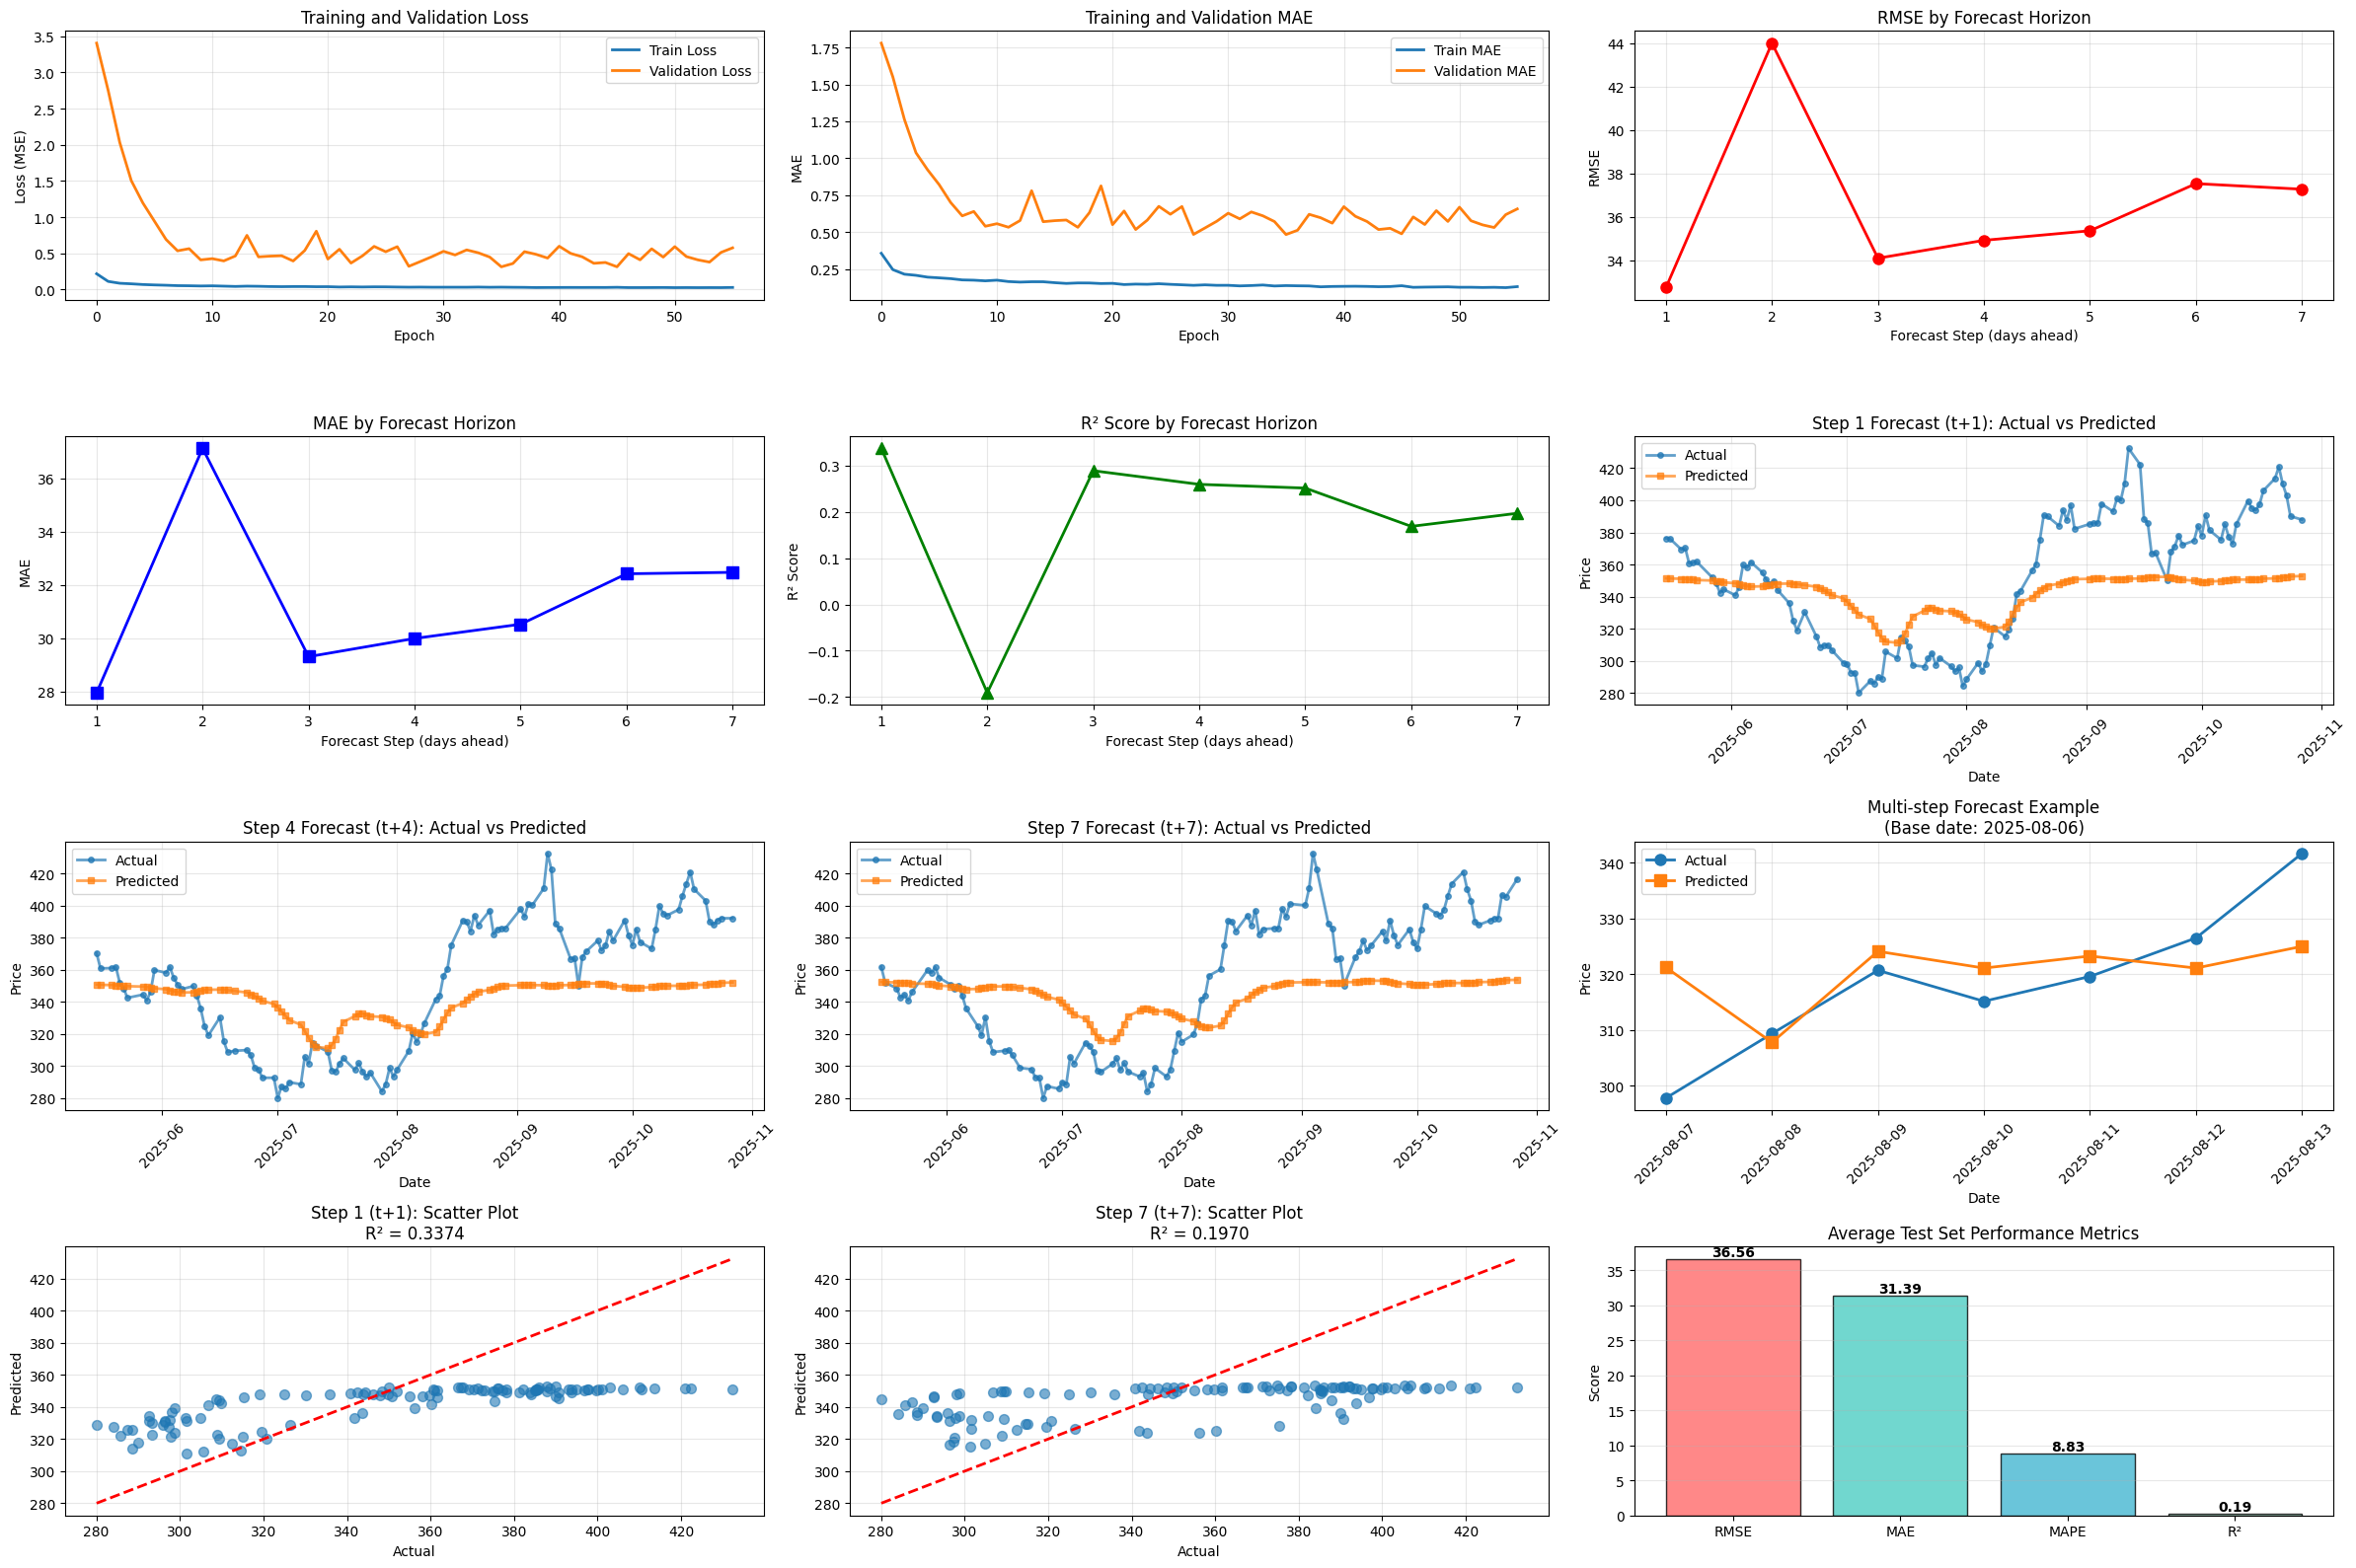


[13단계] 추가 시각화: 예측 궤적 비교
--------------------------------------------------------------------------------
✓ 추가 시각화를 'multistep_lstm_trajectories.png'에 저장했습니다.


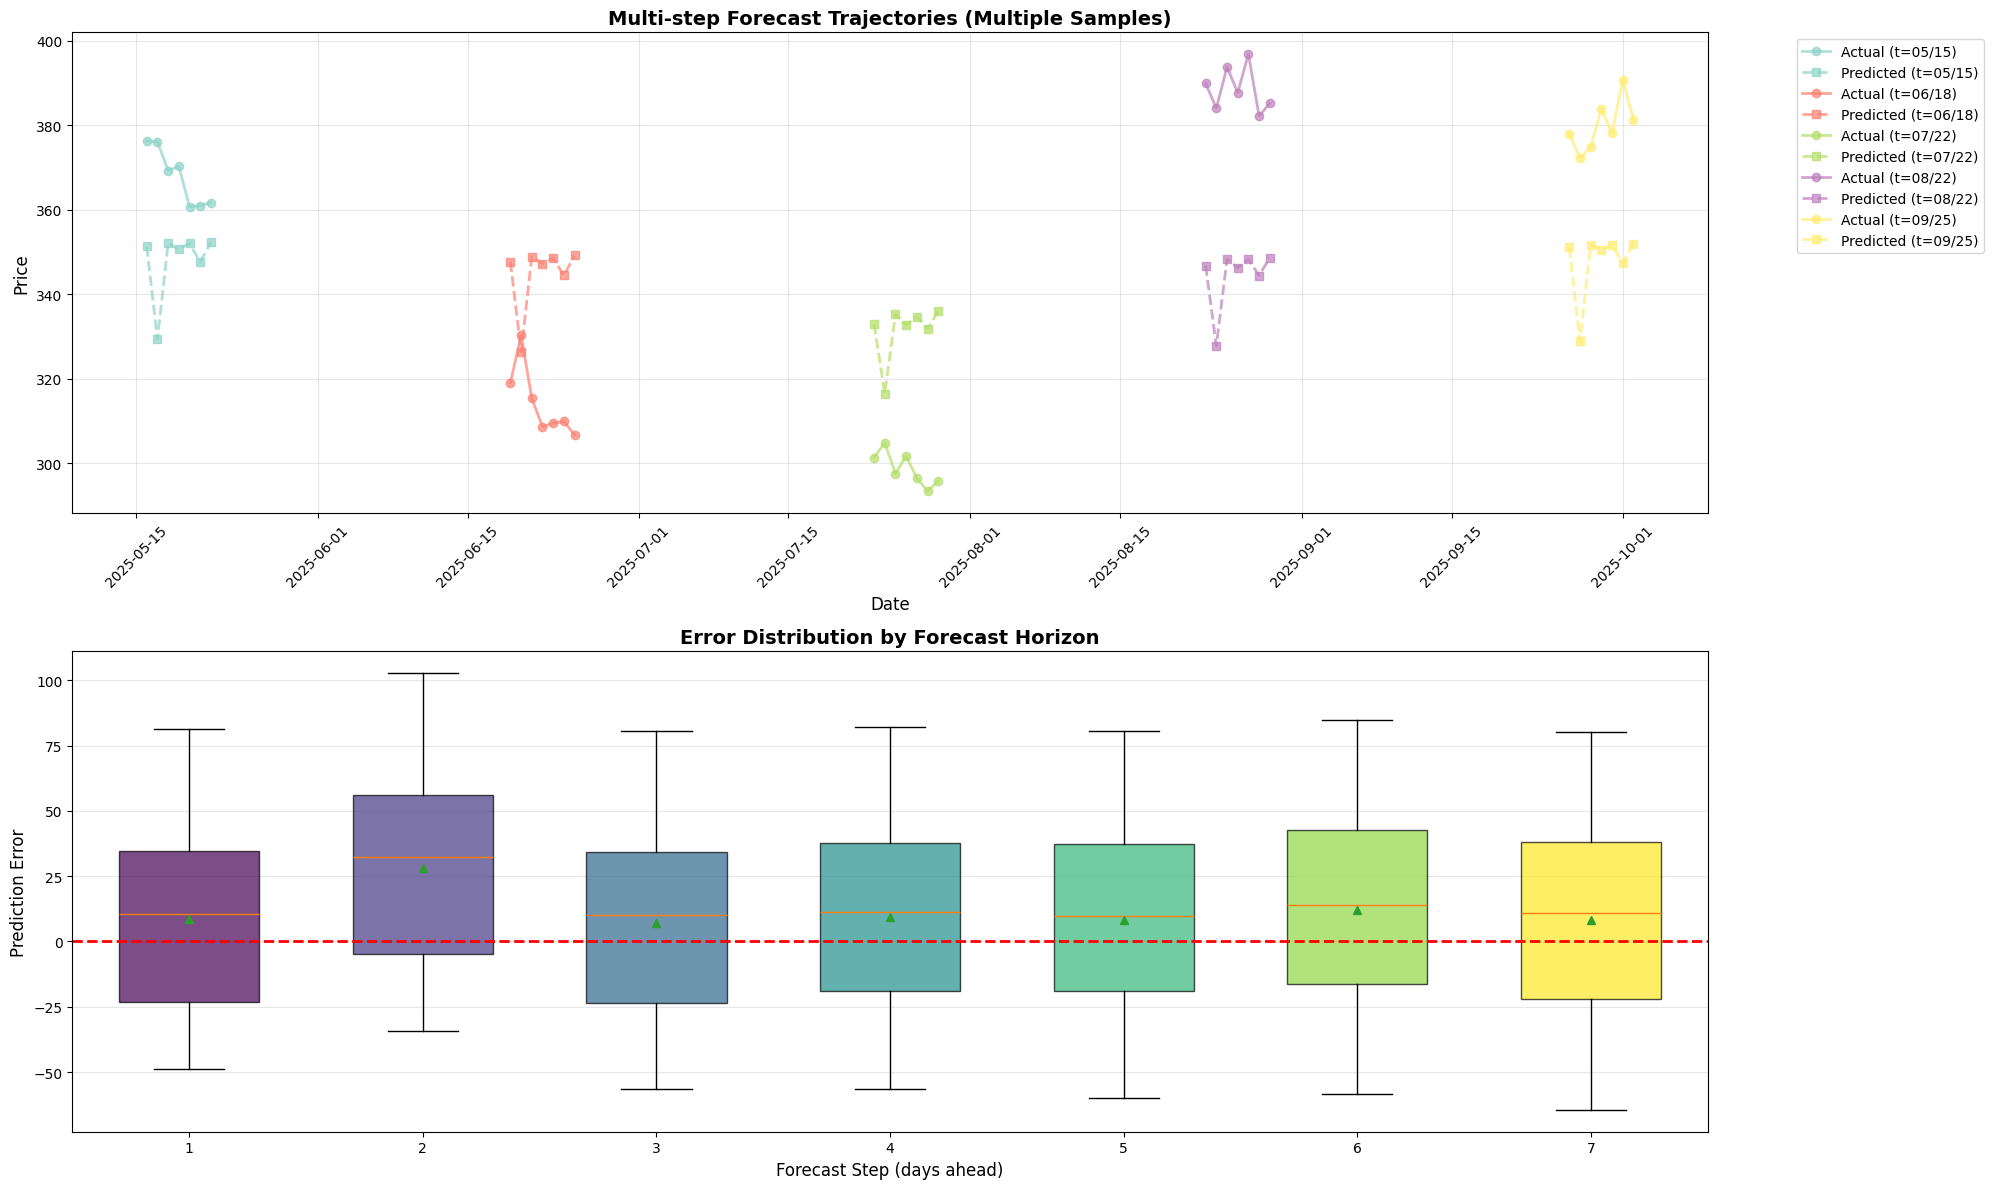


[14단계] 모델 저장
--------------------------------------------------------------------------------
✓ Multi-step LSTM 모델을 'multistep_lstm_model.h5'에 저장했습니다.
✓ Scaler를 'scaler_X_multistep.pkl', 'scaler_y_multistep.pkl'에 저장했습니다.

[15단계] 결과 요약 저장
--------------------------------------------------------------------------------

✅ 모든 프로세스 완료!

생성된 파일:
  1. multistep_lstm_model.h5 - 학습된 Multi-step LSTM 모델
  2. scaler_X_multistep.pkl, scaler_y_multistep.pkl - Feature 및 Target Scaler
  3. multistep_performance_by_step.csv - 각 예측 시점별 성능
  4. model_summary_multistep_lstm.csv - 모델 평균 성능 요약
  5. test_predictions_multistep_lstm.csv - Test set 예측 결과
  6. multistep_lstm_results.png - 결과 시각화 차트 (12개 서브플롯)
  7. multistep_lstm_trajectories.png - 예측 궤적 비교 차트

Multi-Step 예측 설정:
  - Look-back window: 10일
  - Forecast horizon: 7일

최종 Test Set 평균 성능:
  - RMSE: 36.5601
  - MAE: 31.3933
  - MAPE: 8.8310%
  - R² Score: 0.1875

각 예측 시점별 RMSE:
  - Step 1 (+1일): 32.7392
  - Step 2 (+2일): 44.0026
  - Step 3 (+3일): 34.09

In [ ]:
"""
LSTM Multi-Step Ahead 시계열 예측 모델
커피 선물 가격 예측을 위한 전체 프로세스
(One-step ahead → Multi-step ahead 변환)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("LSTM Multi-Step Ahead 시계열 예측 모델 학습 시작")
print("=" * 80)

# ============================================================================
# 1. 데이터 로드 및 기본 탐색
# ============================================================================
print("\n[1단계] 데이터 로드 및 기본 탐색")
print("-" * 80)

# 데이터 로드
# df = pd.read_csv('/mnt/user-data/uploads/coffee_features_clean.csv')

print(f"데이터 shape: {df.shape}")
print(f"결측치 개수: {df.isnull().sum().sum()} 개")
print(f"데이터 타입:\n{df.dtypes.value_counts()}")

# ============================================================================
# 2. 시계열 특성 파악
# ============================================================================
print("\n[2단계] 시계열 특성 파악")
print("-" * 80)

# Date를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'])
print(f"날짜 범위: {df['Date'].min()} ~ {df['Date'].max()}")
print(f"총 {len(df)}일 데이터")

# Target 변수 기본 통계
print(f"\ntarget_next_close 통계:")
print(f"  - 평균: {df['target_next_close'].mean():.2f}")
print(f"  - 표준편차: {df['target_next_close'].std():.2f}")
print(f"  - 최소값: {df['target_next_close'].min():.2f}")
print(f"  - 최대값: {df['target_next_close'].max():.2f}")

# ============================================================================
# 3. Feature 선택 및 전처리
# ============================================================================
print("\n[3단계] Feature 선택 및 전처리")
print("-" * 80)

# 결측치 제거
df = df.dropna()
print(f"결측치 제거 후 데이터 shape: {df.shape}")

# Date 컬럼 분리 (나중에 시각화에 사용)
dates = df['Date'].values

# 제외할 컬럼 정의
columns_to_drop = ['Date', 'target_next_close']
print(f"제외할 컬럼: {columns_to_drop}")

# Feature와 Target 분리
X = df.drop(columns_to_drop, axis=1).values
y = df['target_next_close'].values

print(f"\nFeature 개수: {X.shape[1]}")
print(f"샘플 개수: {X.shape[0]}")

# ============================================================================
# 4. 데이터 정규화
# ============================================================================
print("\n[4단계] 데이터 정규화")
print("-" * 80)

# Feature와 Target 각각 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("✓ Feature와 Target 정규화 완료")

# ============================================================================
# 5. Multi-Step 시퀀스 데이터 생성
# ============================================================================
print("\n[5단계] Multi-Step 시퀀스 데이터 생성")
print("-" * 80)

def create_multistep_sequences(X, y, time_steps=10, forecast_steps=5):
    """
    Multi-step ahead 예측을 위한 시계열 데이터를 LSTM용 시퀀스로 변환

    Parameters:
    - X: Feature 데이터
    - y: Target 데이터
    - time_steps: Look-back 윈도우 크기 (과거 몇 일의 데이터를 볼 것인가)
    - forecast_steps: 예측할 미래 시점 개수 (몇 일 후까지 예측할 것인가)

    Returns:
    - X_seq: (samples, time_steps, features) 형태의 3D 배열
    - y_seq: (samples, forecast_steps) 형태의 2D 배열

    Example:
    - time_steps=10, forecast_steps=5인 경우
    - 과거 10일의 데이터로 미래 5일의 가격을 예측
    """
    X_seq, y_seq = [], []

    for i in range(time_steps, len(X) - forecast_steps + 1):
        # 입력: 과거 time_steps 기간의 데이터
        X_seq.append(X[i-time_steps:i])
        # 출력: 현재 시점부터 forecast_steps 기간의 target 값
        y_seq.append(y[i:i+forecast_steps])

    return np.array(X_seq), np.array(y_seq)

# Multi-step 설정
TIME_STEPS = 10  # 과거 10일 데이터 사용
FORECAST_STEPS = 7  # 미래 7일 예측

X_seq, y_seq = create_multistep_sequences(X_scaled, y_scaled, TIME_STEPS, FORECAST_STEPS)

print(f"Multi-step 시퀀스 데이터 shape:")
print(f"  - X_seq: {X_seq.shape} (samples, time_steps, features)")
print(f"  - y_seq: {y_seq.shape} (samples, forecast_steps)")
print(f"\n설정:")
print(f"  - Look-back window: {TIME_STEPS}일")
print(f"  - Forecast horizon: {FORECAST_STEPS}일")

# 시퀀스 생성 후 날짜도 조정
dates_seq = dates[TIME_STEPS:len(X_seq)+TIME_STEPS]

# ============================================================================
# 6. 데이터 분할 (Train/Test)
# ============================================================================
print("\n[6단계] 데이터 분할 (Train/Test)")
print("-" * 80)

# Train/Test 분할 (시계열 순서 유지, 마지막 10%를 Test로)
train_size = int(len(X_seq) * 0.9)

X_train = X_seq[:train_size]
X_test = X_seq[train_size:]
y_train = y_seq[:train_size]
y_test = y_seq[train_size:]

dates_train = dates_seq[:train_size]
dates_test = dates_seq[train_size:]

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Train 기간: {pd.to_datetime(dates_train[0])} ~ {pd.to_datetime(dates_train[-1])}")
print(f"Test 기간: {pd.to_datetime(dates_test[0])} ~ {pd.to_datetime(dates_test[-1])}")

# ============================================================================
# 7. Multi-Step LSTM 모델 구축
# ============================================================================
print("\n[7단계] Multi-Step LSTM 모델 구축")
print("-" * 80)

def build_multistep_lstm_model(input_shape, forecast_steps):
    """
    Multi-step ahead 예측을 위한 LSTM 모델 구축

    Parameters:
    - input_shape: (time_steps, features) 형태
    - forecast_steps: 예측할 미래 시점 개수

    Returns:
    - model: 컴파일된 Multi-step LSTM 모델
    """
    model = Sequential([
        # 첫 번째 LSTM 레이어
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # 두 번째 LSTM 레이어
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),

        # 세 번째 LSTM 레이어
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),

        # Dense 레이어
        Dense(units=32, activation='relu'),
        Dropout(0.1),

        Dense(units=16, activation='relu'),
        Dropout(0.1),

        # 출력 레이어 - forecast_steps 개의 예측값 출력
        Dense(units=forecast_steps)
    ])

    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# 모델 생성
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_multistep_lstm_model(input_shape, FORECAST_STEPS)

# 모델 구조 출력
print("\n모델 구조:")
model.summary()
print(f"\n출력 차원: {FORECAST_STEPS} (미래 {FORECAST_STEPS}일 예측)")

# ============================================================================
# 8. 콜백 함수 설정
# ============================================================================
print("\n[8단계] 콜백 함수 설정")
print("-" * 80)

# Early Stopping: 검증 손실이 개선되지 않으면 조기 종료
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate 감소: 검증 손실이 개선되지 않으면 학습률 감소
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]
print("✓ EarlyStopping 및 ReduceLROnPlateau 콜백 설정 완료")

# ============================================================================
# 9. 모델 학습
# ============================================================================
print("\n[9단계] 모델 학습")
print("-" * 80)

EPOCHS = 200
BATCH_SIZE = 32

print(f"학습 설정:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Validation split: 0.1")
print("\n학습 시작...")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ 학습 완료!")

# ============================================================================
# 10. 예측 수행
# ============================================================================
print("\n[10단계] 예측 수행")
print("-" * 80)

# 정규화된 예측값
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled = model.predict(X_test, verbose=0)

# 원래 스케일로 역변환
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_train_original = scaler_y.inverse_transform(y_train)
y_test_original = scaler_y.inverse_transform(y_test)

print("✓ 예측 완료 및 역변환 완료!")
print(f"Train 예측 shape: {y_train_pred.shape}")
print(f"Test 예측 shape: {y_test_pred.shape}")

# ============================================================================
# 11. Multi-Step 모델 평가
# ============================================================================
print("\n[11단계] Multi-Step 모델 평가")
print("-" * 80)

def calculate_mape(y_true, y_pred, eps=1e-8):
    """MAPE 계산"""
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# 각 예측 시점별 성능 계산
print("\n📊 각 예측 시점별 성능 (Test Set):")
print("-" * 80)

step_metrics = []
for step in range(FORECAST_STEPS):
    step_rmse = np.sqrt(mean_squared_error(y_test_original[:, step], y_test_pred[:, step]))
    step_mae = mean_absolute_error(y_test_original[:, step], y_test_pred[:, step])
    step_mape = calculate_mape(y_test_original[:, step], y_test_pred[:, step])
    step_r2 = r2_score(y_test_original[:, step], y_test_pred[:, step])

    step_metrics.append({
        'step': step + 1,
        'rmse': step_rmse,
        'mae': step_mae,
        'mape': step_mape,
        'r2': step_r2
    })

    print(f"\nStep {step+1} (+{step+1}일 후):")
    print(f"  - RMSE: {step_rmse:.4f}")
    print(f"  - MAE: {step_mae:.4f}")
    print(f"  - MAPE: {step_mape:.4f}%")
    print(f"  - R² Score: {step_r2:.4f}")

# 전체 평균 성능
print("\n" + "=" * 80)
print("📊 전체 평균 성능 (Test Set):")
print("-" * 80)

avg_rmse = np.mean([m['rmse'] for m in step_metrics])
avg_mae = np.mean([m['mae'] for m in step_metrics])
avg_mape = np.mean([m['mape'] for m in step_metrics])
avg_r2 = np.mean([m['r2'] for m in step_metrics])

print(f"  - 평균 RMSE: {avg_rmse:.4f}")
print(f"  - 평균 MAE: {avg_mae:.4f}")
print(f"  - 평균 MAPE: {avg_mape:.4f}%")
print(f"  - 평균 R² Score: {avg_r2:.4f}")

# Train set 평균 성능도 계산
train_rmse = np.sqrt(mean_squared_error(y_train_original.flatten(), y_train_pred.flatten()))
train_mae = mean_absolute_error(y_train_original.flatten(), y_train_pred.flatten())
train_mape = calculate_mape(y_train_original.flatten(), y_train_pred.flatten())
train_r2 = r2_score(y_train_original.flatten(), y_train_pred.flatten())

print("\n📊 Train Set 평균 성능:")
print("-" * 80)
print(f"  - RMSE: {train_rmse:.4f}")
print(f"  - MAE: {train_mae:.4f}")
print(f"  - MAPE: {train_mape:.4f}%")
print(f"  - R² Score: {train_r2:.4f}")

# ============================================================================
# 12. Multi-Step 결과 시각화
# ============================================================================
print("\n[12단계] Multi-Step 결과 시각화")
print("-" * 80)

fig = plt.figure(figsize=(24, 16))

# 1) 학습 곡선 (Loss)
ax1 = plt.subplot(4, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2) 학습 곡선 (MAE)
ax2 = plt.subplot(4, 3, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# 3) 각 예측 시점별 RMSE 비교
ax3 = plt.subplot(4, 3, 3)
steps = [m['step'] for m in step_metrics]
rmses = [m['rmse'] for m in step_metrics]
plt.plot(steps, rmses, 'o-', linewidth=2, markersize=8, color='red')
plt.xlabel('Forecast Step (days ahead)')
plt.ylabel('RMSE')
plt.title('RMSE by Forecast Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(steps)

# 4) 각 예측 시점별 MAE 비교
ax4 = plt.subplot(4, 3, 4)
maes = [m['mae'] for m in step_metrics]
plt.plot(steps, maes, 's-', linewidth=2, markersize=8, color='blue')
plt.xlabel('Forecast Step (days ahead)')
plt.ylabel('MAE')
plt.title('MAE by Forecast Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(steps)

# 5) 각 예측 시점별 R² 비교
ax5 = plt.subplot(4, 3, 5)
r2s = [m['r2'] for m in step_metrics]
plt.plot(steps, r2s, '^-', linewidth=2, markersize=8, color='green')
plt.xlabel('Forecast Step (days ahead)')
plt.ylabel('R² Score')
plt.title('R² Score by Forecast Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(steps)

# 6) Test Set - 첫 번째 예측 시점 (t+1) 시계열
ax6 = plt.subplot(4, 3, 6)
plt.plot(dates_test, y_test_original[:, 0], 'o-', label='Actual',
         linewidth=2, markersize=4, alpha=0.7)
plt.plot(dates_test, y_test_pred[:, 0], 's-', label='Predicted',
         linewidth=2, markersize=4, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Step 1 Forecast (t+1): Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 7) Test Set - 중간 예측 시점 시계열
mid_step = FORECAST_STEPS // 2
ax7 = plt.subplot(4, 3, 7)
plt.plot(dates_test, y_test_original[:, mid_step], 'o-', label='Actual',
         linewidth=2, markersize=4, alpha=0.7)
plt.plot(dates_test, y_test_pred[:, mid_step], 's-', label='Predicted',
         linewidth=2, markersize=4, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Step {mid_step+1} Forecast (t+{mid_step+1}): Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 8) Test Set - 마지막 예측 시점 시계열
ax8 = plt.subplot(4, 3, 8)
plt.plot(dates_test, y_test_original[:, -1], 'o-', label='Actual',
         linewidth=2, markersize=4, alpha=0.7)
plt.plot(dates_test, y_test_pred[:, -1], 's-', label='Predicted',
         linewidth=2, markersize=4, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Step {FORECAST_STEPS} Forecast (t+{FORECAST_STEPS}): Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 9) Multi-step 예측 예시 (특정 시점의 모든 예측 표시)
ax9 = plt.subplot(4, 3, 9)
sample_idx = len(dates_test) // 2  # 중간 시점 선택
base_date = dates_test[sample_idx]
future_dates = pd.date_range(start=base_date, periods=FORECAST_STEPS+1, freq='D')[1:]

plt.plot(future_dates, y_test_original[sample_idx], 'o-',
         label='Actual', linewidth=2, markersize=8)
plt.plot(future_dates, y_test_pred[sample_idx], 's-',
         label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Multi-step Forecast Example\n(Base date: {pd.to_datetime(base_date).strftime("%Y-%m-%d")})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 10) 각 시점별 Scatter Plot (첫 번째 시점)
ax10 = plt.subplot(4, 3, 10)
plt.scatter(y_test_original[:, 0], y_test_pred[:, 0], alpha=0.6, s=50)
plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         [y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Step 1 (t+1): Scatter Plot\nR² = {step_metrics[0]["r2"]:.4f}')
plt.grid(True, alpha=0.3)

# 11) 각 시점별 Scatter Plot (마지막 시점)
ax11 = plt.subplot(4, 3, 11)
plt.scatter(y_test_original[:, -1], y_test_pred[:, -1], alpha=0.6, s=50)
plt.plot([y_test_original[:, -1].min(), y_test_original[:, -1].max()],
         [y_test_original[:, -1].min(), y_test_original[:, -1].max()],
         'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Step {FORECAST_STEPS} (t+{FORECAST_STEPS}): Scatter Plot\nR² = {step_metrics[-1]["r2"]:.4f}')
plt.grid(True, alpha=0.3)

# 12) 평균 성능 메트릭 막대 그래프
ax12 = plt.subplot(4, 3, 12)
metrics_names = ['RMSE', 'MAE', 'MAPE', 'R²']
scores = [avg_rmse, avg_mae, avg_mape, avg_r2]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(metrics_names, scores, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Score')
plt.title('Average Test Set Performance Metrics')
plt.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/sample_data/multistep_lstm_results.png', dpi=300, bbox_inches='tight')
print("✓ 시각화 결과를 'multistep_lstm_results.png'에 저장했습니다.")
plt.show()
plt.close()

# ============================================================================
# 13. 추가 시각화: 예측 궤적 비교
# ============================================================================
print("\n[13단계] 추가 시각화: 예측 궤적 비교")
print("-" * 80)

fig2, axes = plt.subplots(2, 1, figsize=(20, 12))

# 상단: 여러 샘플의 multi-step 예측 궤적
ax_top = axes[0]
n_samples = min(5, len(dates_test))  # 최대 5개 샘플
colors_samples = plt.cm.Set3(np.linspace(0, 1, n_samples))

for i in range(n_samples):
    idx = i * (len(dates_test) // n_samples)
    base_date = dates_test[idx]
    future_dates = pd.date_range(start=base_date, periods=FORECAST_STEPS+1, freq='D')[1:]

    ax_top.plot(future_dates, y_test_original[idx], 'o-',
                label=f'Actual (t={pd.to_datetime(base_date).strftime("%m/%d")})',
                linewidth=2, markersize=6, color=colors_samples[i], alpha=0.7)
    ax_top.plot(future_dates, y_test_pred[idx], 's--',
                label=f'Predicted (t={pd.to_datetime(base_date).strftime("%m/%d")})',
                linewidth=2, markersize=6, color=colors_samples[i], alpha=0.7)

ax_top.set_xlabel('Date', fontsize=12)
ax_top.set_ylabel('Price', fontsize=12)
ax_top.set_title('Multi-step Forecast Trajectories (Multiple Samples)', fontsize=14, fontweight='bold')
ax_top.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax_top.grid(True, alpha=0.3)
plt.setp(ax_top.xaxis.get_majorticklabels(), rotation=45)

# 하단: 각 예측 시점별 오차 분포
ax_bottom = axes[1]
errors_by_step = []
for step in range(FORECAST_STEPS):
    errors = y_test_original[:, step] - y_test_pred[:, step]
    errors_by_step.append(errors)

positions = range(1, FORECAST_STEPS + 1)
bp = ax_bottom.boxplot(errors_by_step, positions=positions, widths=0.6,
                        patch_artist=True, showmeans=True)

# 박스플롯 색상 설정
for patch, color in zip(bp['boxes'], plt.cm.viridis(np.linspace(0, 1, FORECAST_STEPS))):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax_bottom.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax_bottom.set_xlabel('Forecast Step (days ahead)', fontsize=12)
ax_bottom.set_ylabel('Prediction Error', fontsize=12)
ax_bottom.set_title('Error Distribution by Forecast Horizon', fontsize=14, fontweight='bold')
ax_bottom.grid(True, alpha=0.3, axis='y')
ax_bottom.set_xticks(positions)

plt.tight_layout()
plt.savefig('/content/sample_data/multistep_lstm_trajectories.png', dpi=300, bbox_inches='tight')
print("✓ 추가 시각화를 'multistep_lstm_trajectories.png'에 저장했습니다.")
plt.show()
plt.close()

# ============================================================================
# 14. 모델 저장
# ============================================================================
print("\n[14단계] 모델 저장")
print("-" * 80)

# 모델 저장
model.save('/content/sample_data/multistep_lstm_model.h5')
print("✓ Multi-step LSTM 모델을 'multistep_lstm_model.h5'에 저장했습니다.")

# Scaler 저장
import joblib
joblib.dump(scaler_X, '/content/sample_data/scaler_X_multistep.pkl')
joblib.dump(scaler_y, '/content/sample_data/scaler_y_multistep.pkl')
print("✓ Scaler를 'scaler_X_multistep.pkl', 'scaler_y_multistep.pkl'에 저장했습니다.")

# ============================================================================
# 15. 결과 요약 저장
# ============================================================================
print("\n[15단계] 결과 요약 저장")
print("-" * 80)

# 각 시점별 성능 요약
step_summary = pd.DataFrame(step_metrics)
# step_summary.to_csv('/content/sample_data/multistep_performance_by_step.csv', index=False)
# print("✓ 각 시점별 성능을 'multistep_performance_by_step.csv'에 저장했습니다.")

# 전체 평균 성능 요약
summary = {
    'metric': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'train': [train_rmse, train_mae, train_mape, train_r2],
    'test_avg': [avg_rmse, avg_mae, avg_mape, avg_r2]
}

summary_df = pd.DataFrame(summary)
# summary_df.to_csv('/mnt/user-data/outputs/model_summary_multistep_lstm.csv', index=False)
# print("✓ 모델 평균 성능 요약을 'model_summary_multistep_lstm.csv'에 저장했습니다.")

# 예측 결과 저장 (첫 번째와 마지막 시점)
predictions_df = pd.DataFrame({
    'Date': dates_test,
    'Actual_Step1': y_test_original[:, 0],
    'Predicted_Step1': y_test_pred[:, 0],
    'Error_Step1': y_test_original[:, 0] - y_test_pred[:, 0],
    f'Actual_Step{FORECAST_STEPS}': y_test_original[:, -1],
    f'Predicted_Step{FORECAST_STEPS}': y_test_pred[:, -1],
    f'Error_Step{FORECAST_STEPS}': y_test_original[:, -1] - y_test_pred[:, -1]
})
# predictions_df.to_csv('/mnt/user-data/outputs/test_predictions_multistep_lstm.csv', index=False)
# print("✓ Test set 예측 결과를 'test_predictions_multistep_lstm.csv'에 저장했습니다.")

print("\n" + "=" * 80)
print("✅ 모든 프로세스 완료!")
print("=" * 80)
print("\n생성된 파일:")
print("  1. multistep_lstm_model.h5 - 학습된 Multi-step LSTM 모델")
print("  2. scaler_X_multistep.pkl, scaler_y_multistep.pkl - Feature 및 Target Scaler")
print("  3. multistep_performance_by_step.csv - 각 예측 시점별 성능")
print("  4. model_summary_multistep_lstm.csv - 모델 평균 성능 요약")
print("  5. test_predictions_multistep_lstm.csv - Test set 예측 결과")
print("  6. multistep_lstm_results.png - 결과 시각화 차트 (12개 서브플롯)")
print("  7. multistep_lstm_trajectories.png - 예측 궤적 비교 차트")

print("\n" + "=" * 80)
print(f"Multi-Step 예측 설정:")
print(f"  - Look-back window: {TIME_STEPS}일")
print(f"  - Forecast horizon: {FORECAST_STEPS}일")
print("=" * 80)

print("\n최종 Test Set 평균 성능:")
print(f"  - RMSE: {avg_rmse:.4f}")
print(f"  - MAE: {avg_mae:.4f}")
print(f"  - MAPE: {avg_mape:.4f}%")
print(f"  - R² Score: {avg_r2:.4f}")

print("\n각 예측 시점별 RMSE:")
for m in step_metrics:
    print(f"  - Step {m['step']} (+{m['step']}일): {m['rmse']:.4f}")

print("=" * 80)